# Analiza "Polish companies bankruptcy"


In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
directory_path = "../dbs/polish+companies+bankruptcy+data/"

dfs = []
for i in range(1, 6):
    file_path = f"{directory_path}{i}year.arff"
    raw_data = arff.loadarff(file_path)
    tmpdf = pd.DataFrame(raw_data[0])
    dfs.append(tmpdf)

df = pd.concat(dfs, ignore_index=True)

print(df.shape)
df.head()

(43405, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [3]:
# Liczba i nazwy atrybutów
attribute_count = df.shape[1] - 1  # Odejmujemy 1, ponieważ jedna kolumna to etykieta klasy
attribute_names = df.columns[:-1].tolist()  # Pomijamy kolumnę 'Alcohol'
attribute_count, attribute_names

(64,
 ['Attr1',
  'Attr2',
  'Attr3',
  'Attr4',
  'Attr5',
  'Attr6',
  'Attr7',
  'Attr8',
  'Attr9',
  'Attr10',
  'Attr11',
  'Attr12',
  'Attr13',
  'Attr14',
  'Attr15',
  'Attr16',
  'Attr17',
  'Attr18',
  'Attr19',
  'Attr20',
  'Attr21',
  'Attr22',
  'Attr23',
  'Attr24',
  'Attr25',
  'Attr26',
  'Attr27',
  'Attr28',
  'Attr29',
  'Attr30',
  'Attr31',
  'Attr32',
  'Attr33',
  'Attr34',
  'Attr35',
  'Attr36',
  'Attr37',
  'Attr38',
  'Attr39',
  'Attr40',
  'Attr41',
  'Attr42',
  'Attr43',
  'Attr44',
  'Attr45',
  'Attr46',
  'Attr47',
  'Attr48',
  'Attr49',
  'Attr50',
  'Attr51',
  'Attr52',
  'Attr53',
  'Attr54',
  'Attr55',
  'Attr56',
  'Attr57',
  'Attr58',
  'Attr59',
  'Attr60',
  'Attr61',
  'Attr62',
  'Attr63',
  'Attr64'])

In [4]:
# Mapowanie nazw atrybutów na ich znaczenie
attribute_mapping = {
    'Attr1': 'net profit / total assets',
    'Attr2': 'total liabilities / total assets',
    'Attr3': 'working capital / total assets',
    'Attr4': 'current assets / short-term liabilities',
    'Attr5': '((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365',
    'Attr6': 'retained earnings / total assets',
    'Attr7': 'EBIT / total assets',
    'Attr8': 'book value of equity / total liabilities',
    'Attr9': 'sales / total assets',
    'Attr10': 'equity / total assets',
    'Attr11': '(gross profit + extraordinary items + financial expenses) / total assets',
    'Attr12': 'gross profit / short-term liabilities',
    'Attr13': '(gross profit + depreciation) / sales',
    'Attr14': '(gross profit + interest) / total assets',
    'Attr15': '(total liabilities * 365) / (gross profit + depreciation)',
    'Attr16': '(gross profit + depreciation) / total liabilities',
    'Attr17': 'total assets / total liabilities',
    'Attr18': 'gross profit / total assets',
    'Attr19': 'gross profit / sales',
    'Attr20': '(inventory * 365) / sales',
    'Attr21': 'sales (n) / sales (n-1)',
    'Attr22': 'profit on operating activities / total assets',
    'Attr23': 'net profit / sales',
    'Attr24': 'gross profit (in 3 years) / total assets',
    'Attr25': '(equity - share capital) / total assets',
    'Attr26': '(net profit + depreciation) / total liabilities',
    'Attr27': 'profit on operating activities / financial expenses',
    'Attr28': 'working capital / fixed assets',
    'Attr29': 'logarithm of total assets',
    'Attr30': '(total liabilities - cash) / sales',
    'Attr31': '(gross profit + interest) / sales',
    'Attr32': '(current liabilities * 365) / cost of products sold',
    'Attr33': 'operating expenses / short-term liabilities',
    'Attr34': 'operating expenses / total liabilities',
    'Attr35': 'profit on sales / total assets',
    'Attr36': 'total sales / total assets',
    'Attr37': '(current assets - inventories) / long-term liabilities',
    'Attr38': 'constant capital / total assets',
    'Attr39': 'profit on sales / sales',
    'Attr40': '(current assets - inventory - receivables) / short-term liabilities',
    'Attr41': 'total liabilities / ((profit on operating activities + depreciation) * (12/365))',
    'Attr42': 'profit on operating activities / sales',
    'Attr43': 'rotation receivables + inventory turnover in days',
    'Attr44': '(receivables * 365) / sales',
    'Attr45': 'net profit / inventory',
    'Attr46': '(current assets - inventory) / short-term liabilities',
    'Attr47': '(inventory * 365) / cost of products sold',
    'Attr48': 'EBITDA (profit on operating activities - depreciation) / total assets',
    'Attr49': 'EBITDA (profit on operating activities - depreciation) / sales',
    'Attr50': 'current assets / total liabilities',
    'Attr51': 'short-term liabilities / total assets',
    'Attr52': '(short-term liabilities * 365) / cost of products sold',
    'Attr53': 'equity / fixed assets',
    'Attr54': 'constant capital / fixed assets',
    'Attr55': 'working capital',
    'Attr56': '(sales - cost of products sold) / sales',
    'Attr57': '(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)',
    'Attr58': 'total costs /total sales',
    'Attr59': 'long-term liabilities / equity',
    'Attr60': 'sales / inventory',
    'Attr61': 'sales / receivables',
    'Attr62': '(short-term liabilities *365) / sales',
    'Attr63': 'sales / short-term liabilities',
    'Attr64': 'sales / fixed assets'
}
df.columns = [attribute_mapping.get(col, col) for col in df.columns]
# print(df.columns.tolist())

In [5]:
# export df to csv
df.to_csv('polish_companies_bankruptcy.csv', index=False)
df

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,class
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.38825,0.249760,1.33050,1.13890,0.504940,...,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,b'0'
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.00000,0.258340,0.99601,1.69960,0.497880,...,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700,b'0'
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.00000,0.309060,0.43695,1.30900,0.304080,...,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.20780,b'0'
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.14988,0.092704,1.86610,1.05710,0.573530,...,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.54970,b'0'
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.18732,0.187320,0.63070,1.15590,0.386770,...,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.89800,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,0.012898,0.70621,0.038857,1.17220,-18.9070,0.00000,0.013981,0.41600,1.67680,0.293790,...,0.020169,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990,b'1'
43401,-0.578050,0.96702,-0.800850,0.16576,-67.3650,-0.57805,-0.578050,-0.40334,0.93979,-0.390040,...,-0.064073,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050,b'1'
43402,-0.179050,1.25530,-0.275990,0.74554,-120.4400,-0.17905,-0.154930,-0.26018,1.17490,-0.326590,...,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270,b'1'
43403,-0.108860,0.74394,0.015449,1.08780,-17.0030,-0.10886,-0.109180,0.12531,0.84516,0.093224,...,-0.183200,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575,b'1'


In [6]:
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data

(current assets - inventories) / long-term liabilities                                           18984
sales (n) / sales (n-1)                                                                           5854
profit on operating activities / financial expenses                                               2764
sales / inventory                                                                                 2152
net profit / inventory                                                                            2147
                                                                                                 ...  
equity / total assets                                                                                8
(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)        7
long-term liabilities / equity                                                                       7
working capital                                                          

In [7]:
# df_clean = df.dropna()
# df_clean.shape

## Usunięcie kolumn gdzie brakuje więcej niż 3000 danych i wypełnienie brakujących danych KNNImputerem

In [8]:
columns_to_drop = df.columns[df.isnull().sum() > 3000]
df_dropped = df.drop(columns=columns_to_drop)

# Przygotowanie danych dla KNN imputacji (bez kolumny 'class', jeśli istnieje)
if 'class' in df_dropped.columns:
    X = df_dropped.drop(columns=['class'])
    y = df_dropped['class']
else:
    X = df_dropped
    y = None

# Utworzenie i zastosowanie KNN imputera
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_imputed = imputer.fit_transform(X)

# Przywrócenie DataFrame
df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
if y is not None:
    df_imputed['class'] = y.values

# Wyświetlenie informacji o nowym zbiorze danych
df_imputed.info(), columns_to_drop.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 63 columns):
 #   Column                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                               --------------  -----  
 0   net profit / total assets                                                                                            43405 non-null  float64
 1   total liabilities / total assets                                                                                     43405 non-null  float64
 2   working capital / total assets                                                                                       43405 non-null  float64
 3   current assets / short-term liabilities                                                                              43405 non-null  float64
 4   ((cash + s

(None,
 ['sales (n) / sales (n-1)',
  '(current assets - inventories) / long-term liabilities'])

In [9]:
df = df_imputed
missing_data = df.isnull().sum().sort_values(ascending=False)
print(missing_data)
print(df.shape)
df.head()

net profit / total assets             0
current assets / total liabilities    0
total sales / total assets            0
constant capital / total assets       0
profit on sales / sales               0
                                     ..
working capital / fixed assets        0
logarithm of total assets             0
(total liabilities - cash) / sales    0
(gross profit + interest) / sales     0
class                                 0
Length: 63, dtype: int64
(43405, 63)


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [10]:
scaler = MinMaxScaler()

# Normalizacja danych
X_scaled = scaler.fit_transform(X)

# Przywrócenie znormalizowanych danych do DataFrame
df_normalized = pd.DataFrame(X_scaled, columns=X.columns)
df_normalized['class'] = df_imputed['class'].values

df_normalized.head()

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,class
0,0.831450,0.472949,0.945033,0.000046,0.904960,0.483805,0.443752,0.002664,0.000476,0.304174,...,0.999736,0.751235,0.00018,0.013563,0.000004,0.000165,0.085425,0.000254,0.034980,b'0'
1,0.831466,0.473081,0.945182,0.000044,0.904959,0.483436,0.443759,0.002658,0.000533,0.304169,...,0.999736,0.751246,0.00018,0.013563,0.000003,0.000147,0.085426,0.000211,0.035155,b'0'
2,0.831536,0.473296,0.944778,0.000037,0.904958,0.483436,0.443803,0.002648,0.000493,0.304046,...,0.999736,0.751425,0.00018,0.013592,0.000004,0.000154,0.085427,0.000182,0.034972,b'0'
3,0.831237,0.472870,0.945156,0.000054,0.904962,0.483578,0.443617,0.002674,0.000467,0.304217,...,0.999736,0.751120,0.00018,0.013563,0.000004,0.000151,0.085425,0.000246,0.034973,b'0'
4,0.831426,0.473206,0.944705,0.000034,0.904957,0.483614,0.443698,0.002651,0.000477,0.304099,...,0.999736,0.751274,0.00018,0.013568,0.000004,0.000157,0.085426,0.000188,0.034981,b'0'


In [11]:
df_clean = df_normalized.dropna()
df_clean.shape, df_normalized.shape

((36989, 63), (43405, 63))

In [12]:
# count NaN values
df_clean.isnull().sum().sum()

0

In [13]:
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Trenowanie modelu na znormalizowanych danych (bez kolumny 'class')
outliers = iso_forest.fit_predict(df_clean.drop(columns=['class', 'outlier'], errors='ignore'))

# Dodanie wyników do DataFrame
df_clean['outlier'] = outliers

# Wartości -1 oznaczają wykryte wartości odstające, 1 oznacza normalne obserwacje
outliers_detected = df_clean[df_clean['outlier'] == -1]

outliers_detected.head()


/var/folders/58/x_k_tb_50wj9t6kdymtnp5gc0000gn/T/ipykernel_6977/1977763890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['outlier'] = outliers


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,class,outlier
132,0.832423,0.472778,0.945700,0.000088,0.904965,0.484142,0.444323,0.002703,0.000498,0.304336,...,0.751496,0.00018,0.013563,0.000056,0.000171,0.085423,0.000728,0.035229,b'0',-1
285,0.831357,0.472558,0.945621,0.000607,0.904965,0.483436,0.443700,0.003454,0.000597,0.304473,...,0.751125,0.00018,0.013563,0.000006,0.000219,0.085422,0.004495,0.034982,b'0',-1
397,0.831127,0.472614,0.945021,0.000126,0.905181,0.483455,0.443560,0.002874,0.000457,0.304437,...,0.751066,0.00018,0.013563,0.000003,0.000120,0.085449,0.000086,0.034956,b'0',-1
646,0.832716,0.472635,0.945686,0.000173,0.904962,0.483436,0.444315,0.002822,0.000769,0.304428,...,0.751507,0.00018,0.013563,0.000007,0.000206,0.085422,0.001904,0.035028,b'0',-1
653,0.832338,0.472612,0.945622,0.000246,0.904969,0.483436,0.444134,0.002881,0.000575,0.304442,...,0.751394,0.00018,0.013564,0.000006,0.000187,0.085422,0.001587,0.034984,b'0',-1


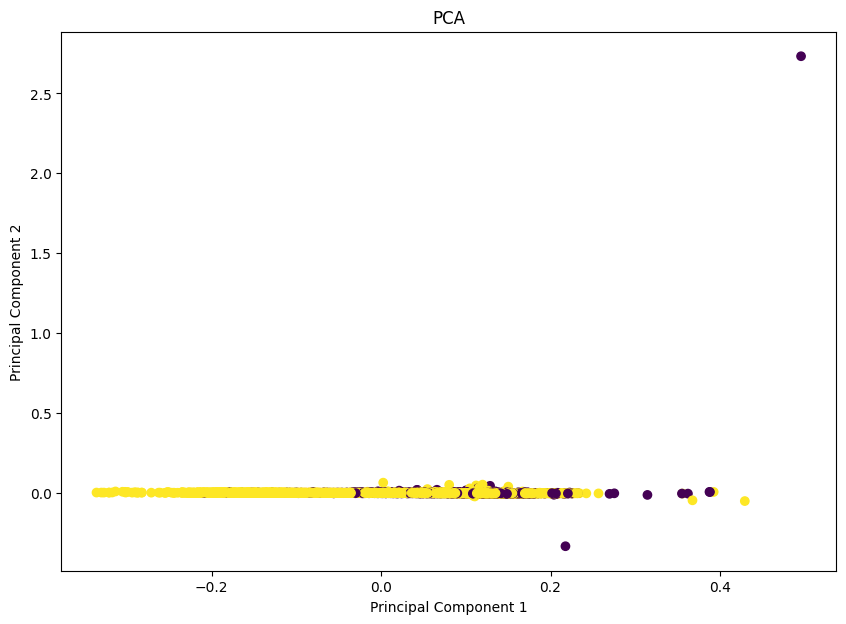

In [14]:
# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_clean.drop(columns=['class', 'outlier'], errors='ignore'))

# plot PCA
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['outlier'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

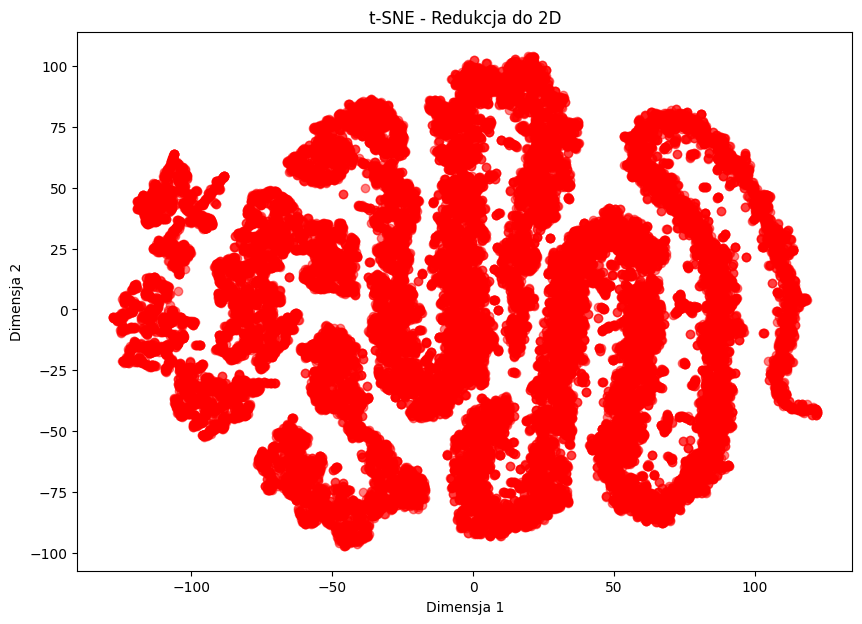

In [15]:
# Inicjalizacja t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Dopasowanie t-SNE do danych
tsne_result = tsne.fit_transform(df_clean.drop(columns=['class', 'outlier'], errors='ignore'))

# Wizualizacja wyników t-SNE
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='red', alpha=0.5)
plt.title('t-SNE - Redukcja do 2D')
plt.xlabel('Dimensja 1')
plt.ylabel('Dimensja 2')
plt.show()


In [16]:
label_encoder = LabelEncoder()

# Zakodowanie etykiet
y_encoded = label_encoder.fit_transform(y)

# Podział danych na zestaw treningowy i testowy z zakodowanymi etykietami
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [17]:
# Inicjalizacja modelu Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Trenowanie modelu
rf.fit(X_train, y_train_encoded)

# Predykcja na zestawie testowym
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"Dokładność modelu Random Forest: {accuracy:.2f}")


Dokładność modelu Random Forest: 0.97
